<a href="https://colab.research.google.com/github/Sasisekhargopidesi/MLP-for-MNIST-Digit-Recognition/blob/main/MLP_assingment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================
# STEP 1: Import Required Libraries
# ===============================

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# ===============================
# STEP 2: Set Random Seed for Reproducibility
# ===============================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ===============================
# STEP 3: Device Configuration
# ===============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# STEP 4: Global Hyperparameters
# ===============================

BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-2
DROPOUT_P = 0.2


Using device: cpu


In [ ]:
# ===============================
# STEP 2: Load and Visualize the MNIST Dataset
# ===============================

# Transform: convert image to tensor and normalize pixel values to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image → Tensor with shape [C, H, W]
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Total training images: {len(train_dataset)}")
print(f"Total testing images: {len(test_dataset)}")

# Split training dataset into training (48k) and validation (12k)
train_size = int(0.8 * len(train_dataset))   # 48,000
val_size = len(train_dataset) - train_size   # 12,000

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Training set: {len(train_data)}, Validation set: {len(val_data)}")

# Create data loaders (these make batching easier later)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 52.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.60MB/s]

Total training images: 60000
Total testing images: 10000
Training set: 48000, Validation set: 12000


In [ ]:
# ===============================
# STEP 2: Load and Visualize the MNIST Dataset
# ===============================

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1  Define the image transformation
#    - Convert image to Tensor
#    - Normalize using MNIST mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean & std for MNIST
])

# 2  Download and load MNIST dataset
root = "./data"

full_train = datasets.MNIST(
    root=root,
    train=True,
    download=True,
    transform=transform
)

test_set = datasets.MNIST(
    root=root,
    train=False,
    download=True,
    transform=transform
)

# 3  Split full training data (60k) into train (55k) and validation (5k)
train_size = 55000
val_size = len(full_train) - train_size

train_set, val_set = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)  # reproducibility
)

# 4️  Create DataLoaders for batching
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train / Val / Test sizes : {len(train_set)} / {len(val_set)} / {len(test_set)}")


Train / Val / Test sizes : 55000 / 5000 / 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


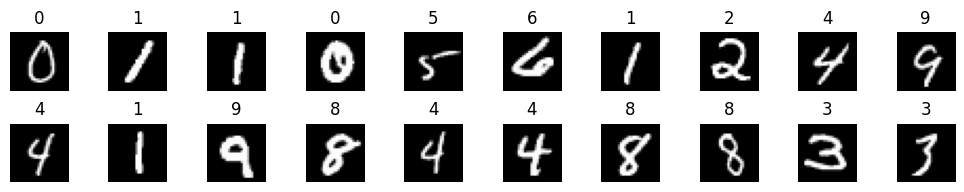

In [ ]:

# -------------------------------
# 3️ Function to visualize a grid of images
# -------------------------------
def show_grid(dloader, n=20):
    # Get first batch of data
    x, y = next(iter(dloader))
    x, y = x[:n], y[:n]  # take first n samples

    plt.figure(figsize=(10, 2))  # create figure

    for i in range(n):
        plt.subplot(2, 10, i + 1)  # 2 rows x 10 columns
        plt.imshow(x[i, 0].cpu().numpy(), cmap="gray")  # plot grayscale image
        plt.title(str(y[i].item()))  # show label
        plt.axis("off")  # remove axes

    plt.tight_layout()
    plt.show()

# -------------------------------
# 4️ Display first 20 training images
# -------------------------------
show_grid(train_loader, n=20)


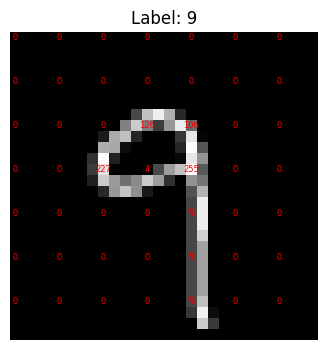

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Function to show one image with pixel values
# -------------------------------
def show_image_with_values(img_tensor, label=None):
    """
    img_tensor: shape (1, 28, 28), normalized
    label: optional, the digit label
    """
    # Convert tensor to numpy array and undo normalization roughly
    img = img_tensor[0].cpu().numpy()
    img_uint = ((img * 0.3081 + 0.1307) * 255.0).clip(0, 255).astype(np.uint8)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_uint, cmap="gray")
    plt.title(f"Label: {label}" if label is not None else "MNIST sample")
    plt.axis("off")

    # Overlay pixel values every 4 pixels
    for r in range(0, 28, 4):
        for c in range(0, 28, 4):
            plt.text(c, r, str(img_uint[r, c]), color="red",
                     fontsize=6, ha="center", va="center")

    plt.show()

# -------------------------------
# Get one batch and display the first image
# -------------------------------
batch_x, batch_y = next(iter(train_loader))
show_image_with_values(batch_x[0], batch_y[0].item())


In [ ]:
import torch
import torch.nn as nn

# -------------------------------
# Hyperparameter for dropout
# -------------------------------
DROPOUT_P = 0.2  # example dropout probability

# -------------------------------
# 1️ Define the MLP class
# -------------------------------
class MLP(nn.Module):
    def __init__(self, hidden_sizes, dropout_p=DROPOUT_P):
        super().__init__()
        layers = []
        in_dim = 28 * 28  # MNIST images are 28x28, flattened

        # Add hidden layers
        for h in hidden_sizes:
            layers += [
                nn.Linear(in_dim, h),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_p)
            ]
            in_dim = h  # input dim for next layer

        # Output layer (10 classes)
        layers += [nn.Linear(in_dim, 10)]  # logits for 10 digits

        # Combine layers into a sequential module
        self.net = nn.Sequential(*layers)

        # Apply He (Kaiming) initialization
        self.apply(self._init_kaiming)

    @staticmethod
    def _init_kaiming(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")  # He initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # bias initialized to 0

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten 28x28 image to vector
        return self.net(x)

# -------------------------------
# 2️ Define architectures (number of hidden layers)
# -------------------------------
architectures = {
    "Model_1HL": [512],
    "Model_2HL": [512, 256],
    "Model_3HL": [512, 256, 128],
    "Model_4HL": [512, 256, 128, 64],
}

# -------------------------------
# 3️ Example: create a 2-hidden-layer model
# -------------------------------
model_2hl = MLP(architectures["Model_2HL"])
print(model_2hl)


MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:

# -------------------------------
# Function to create loss function and optimizer
# -------------------------------
def make_criterion_optimizer(model, lr=LR, weight_decay=0.0):
    """
    Returns:
    - criterion: CrossEntropyLoss for multi-class classification
    - optimizer: SGD optimizer for the model
    """
    # Cross-entropy loss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # SGD optimizer
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.0,      # no momentum as per brief
        weight_decay=weight_decay  # L2 regularization
    )

    return criterion, optimizer

# -------------------------------
# Example usage
# -------------------------------
# Assuming 'model_2hl' from Step 5
criterion, optimizer = make_criterion_optimizer(model_2hl)
print(criterion)
print(optimizer)


CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0.0
)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# -------------------------------
# Hyperparameters
# -------------------------------
EPOCHS = 10  # example number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# 1️ Evaluation function
# -------------------------------
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        total_correct += (pred == y).sum().item()
        total += y.size(0)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(y.cpu().numpy())

    avg_loss = total_loss / total
    acc = total_correct / total
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                   average="macro", zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

    return dict(loss=avg_loss, acc=acc, P=P, R=R, F1=F1, cm=cm)

# -------------------------------
# 2️ Training function
# -------------------------------
def train_one_model(name, hidden_sizes):
    model = MLP(hidden_sizes).to(device)
    criterion, optimizer = make_criterion_optimizer(model, lr=LR)
    best_val_loss = float("inf")
    best_path = f"{name}_best.pt"

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss, running_correct, seen = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            running_correct += (pred == y).sum().item()
            seen += y.size(0)

        tr_loss = running_loss / seen
        tr_acc = running_correct / seen

        val_res = evaluate(model, val_loader, criterion)

        print(f"[{name}] Epoch {epoch:02d} | "
              f"TrainLoss {tr_loss:.4f} Acc {tr_acc:.4f} | "
              f"ValLoss {val_res['loss']:.4f} Acc {val_res['acc']:.4f} | "
              f"P {val_res['P']:.4f} R {val_res['R']:.4f} F1 {val_res['F1']:.4f}")

        # Save best model by validation loss
        if val_res["loss"] < best_val_loss:
            best_val_loss = val_res["loss"]
            torch.save(model.state_dict(), best_path)

    # Reload best checkpoint
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model, best_path

# -------------------------------
# 3️ Example usage
# -------------------------------
# model_2hl_best, path = train_one_model("Model_2HL", architectures["Model_2HL"])
# print(f"Best model saved at: {path}")


In [ ]:
import pandas as pd
import torch.nn as nn

# -------------------------------
# Dictionary to store results
# -------------------------------
results = {}

# -------------------------------
# Train all 4 models
# -------------------------------
for name, arch in architectures.items():
    print(f"\n=== Training {name}, arch = {arch} ===")

    # Train model and get best checkpoint
    model, ckpt = train_one_model(name, arch)

    # Evaluate on test set
    test_metrics = evaluate(model, test_loader, nn.CrossEntropyLoss())

    # Save results
    results[name] = dict(arch=arch, **test_metrics)

    # Print test metrics
    print(f"[{name}] TestLoss {test_metrics['loss']:.4f} | "
          f"Acc {test_metrics['acc']:.4f} | "
          f"P {test_metrics['P']:.4f} R {test_metrics['R']:.4f} F1 {test_metrics['F1']:.4f}")

# -------------------------------
# Comparison table
# -------------------------------
rows = []
for name, r in results.items():
    rows.append({
        "Model": name,
        "Hidden Layers": str(r["arch"]),
        "Accuracy": r["acc"],
        "Precision (macro)": r["P"],
        "Recall (macro)": r["R"],
        "F1 (macro)": r["F1"],
    })

df = pd.DataFrame(rows).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n=== Comparison ===\n", df.to_string(index=False))



=== Training Model_1HL, arch = [512] ===
[Model_1HL] Epoch 01 | TrainLoss 0.6320 Acc 0.8023 | ValLoss 0.3566 Acc 0.8928 | P 0.8926 R 0.8910 F1 0.8912


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 02 | TrainLoss 0.3468 Acc 0.8952 | ValLoss 0.2906 Acc 0.9146 | P 0.9139 R 0.9129 F1 0.9132


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 03 | TrainLoss 0.2883 Acc 0.9151 | ValLoss 0.2551 Acc 0.9248 | P 0.9242 R 0.9237 F1 0.9238


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 04 | TrainLoss 0.2564 Acc 0.9250 | ValLoss 0.2329 Acc 0.9308 | P 0.9303 R 0.9300 F1 0.9301


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 05 | TrainLoss 0.2300 Acc 0.9327 | ValLoss 0.2152 Acc 0.9358 | P 0.9354 R 0.9350 F1 0.9350


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 06 | TrainLoss 0.2143 Acc 0.9379 | ValLoss 0.2018 Acc 0.9404 | P 0.9399 R 0.9398 F1 0.9397


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 07 | TrainLoss 0.1975 Acc 0.9425 | ValLoss 0.1893 Acc 0.9440 | P 0.9434 R 0.9435 F1 0.9434


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 08 | TrainLoss 0.1851 Acc 0.9459 | ValLoss 0.1802 Acc 0.9474 | P 0.9468 R 0.9470 F1 0.9468


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 09 | TrainLoss 0.1751 Acc 0.9495 | ValLoss 0.1727 Acc 0.9488 | P 0.9483 R 0.9483 F1 0.9482


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] Epoch 10 | TrainLoss 0.1649 Acc 0.9522 | ValLoss 0.1644 Acc 0.9508 | P 0.9503 R 0.9503 F1 0.9503


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_1HL] TestLoss 0.1436 | Acc 0.9592 | P 0.9589 R 0.9588 F1 0.9588

=== Training Model_2HL, arch = [512, 256] ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 01 | TrainLoss 0.7069 Acc 0.7723 | ValLoss 0.3187 Acc 0.9054 | P 0.9043 R 0.9035 F1 0.9037


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 02 | TrainLoss 0.3723 Acc 0.8860 | ValLoss 0.2513 Acc 0.9288 | P 0.9284 R 0.9273 F1 0.9276


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 03 | TrainLoss 0.3053 Acc 0.9063 | ValLoss 0.2180 Acc 0.9368 | P 0.9368 R 0.9352 F1 0.9358


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 04 | TrainLoss 0.2671 Acc 0.9175 | ValLoss 0.1953 Acc 0.9434 | P 0.9429 R 0.9425 F1 0.9427


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 05 | TrainLoss 0.2393 Acc 0.9279 | ValLoss 0.1805 Acc 0.9472 | P 0.9473 R 0.9462 F1 0.9466


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 06 | TrainLoss 0.2180 Acc 0.9354 | ValLoss 0.1670 Acc 0.9516 | P 0.9512 R 0.9508 F1 0.9510


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 07 | TrainLoss 0.2018 Acc 0.9392 | ValLoss 0.1581 Acc 0.9538 | P 0.9536 R 0.9531 F1 0.9533


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 08 | TrainLoss 0.1868 Acc 0.9434 | ValLoss 0.1509 Acc 0.9570 | P 0.9569 R 0.9563 F1 0.9565


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 09 | TrainLoss 0.1766 Acc 0.9464 | ValLoss 0.1425 Acc 0.9580 | P 0.9578 R 0.9573 F1 0.9575


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] Epoch 10 | TrainLoss 0.1690 Acc 0.9496 | ValLoss 0.1367 Acc 0.9600 | P 0.9598 R 0.9595 F1 0.9596


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_2HL] TestLoss 0.1251 | Acc 0.9626 | P 0.9625 R 0.9622 F1 0.9623

=== Training Model_3HL, arch = [512, 256, 128] ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 01 | TrainLoss 0.9096 Acc 0.7018 | ValLoss 0.3468 Acc 0.9014 | P 0.9009 R 0.8991 F1 0.8993


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 02 | TrainLoss 0.4597 Acc 0.8579 | ValLoss 0.2685 Acc 0.9216 | P 0.9210 R 0.9202 F1 0.9203


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 03 | TrainLoss 0.3711 Acc 0.8855 | ValLoss 0.2333 Acc 0.9314 | P 0.9308 R 0.9303 F1 0.9304


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 04 | TrainLoss 0.3205 Acc 0.9031 | ValLoss 0.2076 Acc 0.9376 | P 0.9369 R 0.9365 F1 0.9366


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 05 | TrainLoss 0.2837 Acc 0.9123 | ValLoss 0.1935 Acc 0.9420 | P 0.9418 R 0.9409 F1 0.9410


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 06 | TrainLoss 0.2586 Acc 0.9219 | ValLoss 0.1810 Acc 0.9456 | P 0.9451 R 0.9446 F1 0.9446


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 07 | TrainLoss 0.2402 Acc 0.9274 | ValLoss 0.1697 Acc 0.9504 | P 0.9501 R 0.9494 F1 0.9495


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 08 | TrainLoss 0.2212 Acc 0.9308 | ValLoss 0.1615 Acc 0.9508 | P 0.9506 R 0.9498 F1 0.9499


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 09 | TrainLoss 0.2078 Acc 0.9363 | ValLoss 0.1538 Acc 0.9538 | P 0.9536 R 0.9529 F1 0.9530


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] Epoch 10 | TrainLoss 0.1979 Acc 0.9386 | ValLoss 0.1473 Acc 0.9548 | P 0.9543 R 0.9539 F1 0.9540


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_3HL] TestLoss 0.1315 | Acc 0.9585 | P 0.9581 R 0.9581 F1 0.9580

=== Training Model_4HL, arch = [512, 256, 128, 64] ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 01 | TrainLoss 1.1813 Acc 0.6077 | ValLoss 0.3945 Acc 0.8906 | P 0.8892 R 0.8875 F1 0.8877


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 02 | TrainLoss 0.5716 Acc 0.8225 | ValLoss 0.2991 Acc 0.9114 | P 0.9105 R 0.9095 F1 0.9098


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 03 | TrainLoss 0.4451 Acc 0.8646 | ValLoss 0.2608 Acc 0.9196 | P 0.9187 R 0.9181 F1 0.9182


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 04 | TrainLoss 0.3755 Acc 0.8884 | ValLoss 0.2301 Acc 0.9266 | P 0.9261 R 0.9251 F1 0.9254


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 05 | TrainLoss 0.3353 Acc 0.9011 | ValLoss 0.2115 Acc 0.9350 | P 0.9344 R 0.9339 F1 0.9341


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 06 | TrainLoss 0.3017 Acc 0.9104 | ValLoss 0.1970 Acc 0.9402 | P 0.9397 R 0.9392 F1 0.9394


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 07 | TrainLoss 0.2764 Acc 0.9188 | ValLoss 0.1835 Acc 0.9442 | P 0.9436 R 0.9432 F1 0.9433


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 08 | TrainLoss 0.2581 Acc 0.9246 | ValLoss 0.1736 Acc 0.9470 | P 0.9467 R 0.9460 F1 0.9463


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 09 | TrainLoss 0.2372 Acc 0.9305 | ValLoss 0.1648 Acc 0.9500 | P 0.9500 R 0.9490 F1 0.9494


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] Epoch 10 | TrainLoss 0.2285 Acc 0.9335 | ValLoss 0.1576 Acc 0.9500 | P 0.9495 R 0.9493 F1 0.9493


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Model_4HL] TestLoss 0.1373 | Acc 0.9602 | P 0.9598 R 0.9598 F1 0.9597

=== Comparison ===
     Model       Hidden Layers  Accuracy  Precision (macro)  Recall (macro)  F1 (macro)
Model_2HL          [512, 256]    0.9626           0.962492        0.962159    0.962269
Model_4HL [512, 256, 128, 64]    0.9602           0.959790        0.959783    0.959741
Model_1HL               [512]    0.9592           0.958889        0.958786    0.958814
Model_3HL     [512, 256, 128]    0.9585           0.958129        0.958059    0.958025


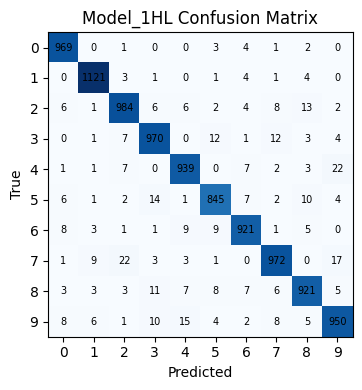

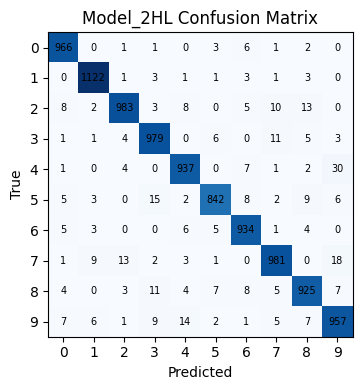

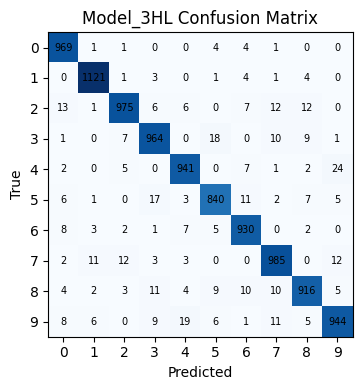

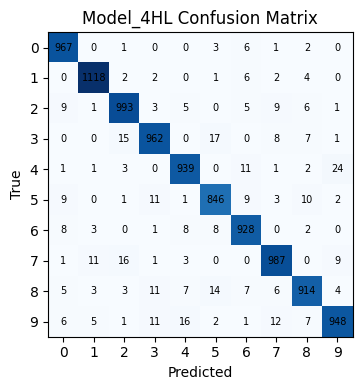

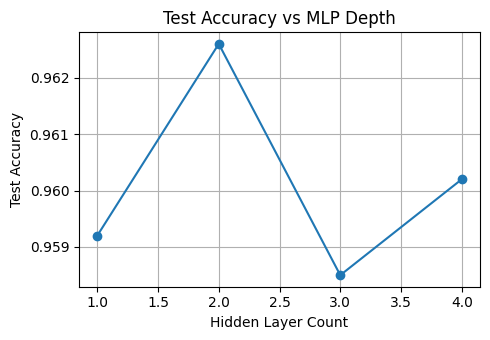

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1️ Function to plot a confusion matrix
# -------------------------------
def plot_cm(cm, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)

    # Annotate each cell with the count
    for i in range(10):
        for j in range(10):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=7)

    plt.tight_layout()
    plt.show()

# -------------------------------
# 2️ Plot confusion matrices for all models
# -------------------------------
for name, r in results.items():
    plot_cm(r["cm"], f"{name} Confusion Matrix")

# -------------------------------
# 3️ Plot Test Accuracy vs Hidden Layer Depth
# -------------------------------
depths = [len(v["arch"]) for v in results.values()]
accs = [v["acc"] for v in results.values()]
order = np.argsort(depths)  # sort by depth

plt.figure(figsize=(5, 3.5))
plt.plot(np.array(depths)[order], np.array(accs)[order], marker="o", linestyle="-")
plt.xlabel("Hidden Layer Count")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs MLP Depth")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

# -------------------------------
# Function to show predictions
# -------------------------------
@torch.no_grad()
def show_predictions(model, loader, n=20):
    """
    Displays n sample predictions from the loader.
    Correct predictions are green, wrong ones are red.
    """
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)

    logits = model(x)
    yhat = logits.argmax(dim=1)

    plt.figure(figsize=(10, 2))

    for i in range(n):
        plt.subplot(2, 10, i + 1)
        plt.imshow(x[i, 0].cpu().numpy(), cmap="gray")

        # Color-coded title
        correct = (yhat[i].item() == y[i].item())
        color = "green" if correct else "red"
        plt.title(f"p:{yhat[i].item()}/t:{y[i].item()}", color=color, fontsize=8)

        plt.axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------------
# Use the best model (highest accuracy)
# -------------------------------
best_name = df.iloc[0]["Model"]
best_arch = architectures[best_name]
best_model = MLP(best_arch).to(device)
best_model.load_state_dict(torch.load(f"{best_name}_best.pt", map_location=device))

# Show 20 sample predictions
show_predictions(best_model, test_loader, n=20)
